In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import pyproteonet

In [7]:
from pathlib import Path
import math

import pandas as pd
import numpy as np
import mpl_scatter_density
import matplotlib
from matplotlib import pyplot as plt
from pyproteonet.metrics.abundance_comparison import compare_columns
from matplotlib import pyplot as plt
import seaborn as sns
from seaborn import boxplot
from tqdm.auto import tqdm

from pyproteonet.data import Dataset
from pyproteonet.metrics.paired_testing import paired_wilcoxon_matrix
from pyproteonet.metrics.differential_expression import find_des

from utils.globals import method_label_map, dataset_label_map

eval_columns = ['mindet', 'minprob', 'median', 'knn', 'missforest', 'bpca', 'isvd', 'vae', 'dae', 'cf', 'iterative', 'gnn_imp']
EVAL_DATASETS = ['breast_cancer', 'blood_ddia', 'maxlfqbench', 'human_ecoli_ddia', 'prostate_cancer', 'crohns_fibrosis']

method_order = ['PEPerMINT', 'RF', 'BPCA', 'MICE', 'CF', 'Median', 'DAE', 'KNN', 'ISVD', 'VAE', 'MinDet', 'MinProb']

from matplotlib.cm import viridis
from matplotlib.colors import ListedColormap
PALETTE = ListedColormap([viridis(1.0),#"#FFA500",
                        '#828217',#g1
                        '#094753',#b1
                        '#D9D926',#g2
                        '#0F758A',#b2
                        "#821717",#r1
                        '#18BCDD',#b3
                        '#E8E87D',#g3
                        '#63D7EE',#b4
                        '#B5ECF7',#b5
                        "#d92626",#r2
                        "#e87d7d",#r3
                        ])
PALETTE
PALETTE = PALETTE.colors

# Load Datasets

In [8]:
from preprocessing import embed_sequences_t5_cached, create_masked_dataset, remove_all_missing
imp_datasets = {}

for ds_name in ['breast_cancer', 'prostate_cancer', 'crohns_fibrosis', 'maxlfqbench', 'blood_ddia', 'human_ecoli_ddia']:#['crohns_disease']:
    print(ds_name)
    ds = Dataset.load(f'data/datasets_imputed/{ds_name}')
    imp_datasets[ds_name] = ds

breast_cancer
prostate_cancer
crohns_fibrosis
maxlfqbench
blood_ddia
human_ecoli_ddia


# Evaluation

## Dataset Characteristics

In [18]:
data = {
    '#Peptides': [],
    '#Proteins': [],
    '#Samples': [],
    'MissingnessCounts': [],
    'Mean': [],
    'Std': [],
    '% Missing Values': []
}
for ds_name, ds in imp_datasets.items():
    perc_missing = ds.values['peptide']['abundance']
    num_peps = ds.molecules['peptide'].shape[0]
    num_prots = ds.molecules['protein'].shape[0]
    num_samples = ds.num_samples
    perc_missing = perc_missing.isna().sum() / perc_missing.shape[0]
    data['#Peptides'].append(num_peps)
    data['#Proteins'].append(num_prots)
    data['#Samples'].append(num_samples)
    missingness_dist = ds.get_wf('peptide', 'abundance').count(axis=1).value_counts()
    data['MissingnessCounts'].append(str(dict(missingness_dist)))
    data['Mean'].append(ds.values['peptide']['abundance'].mean())
    data['Std'].append(ds.values['peptide']['abundance'].std())
    data['% Missing Values'].append(perc_missing * 100)
pd.DataFrame(data, index=imp_datasets.keys())

,#Peptides,#Proteins,#Samples,MissingnessCounts,Mean,Std,% Missing Values
breast_cancer,103608,13627,15,"{1: 29333, 2: 15306, 3: 10461, 4: 8223, 5: 619...",16.248265,1.525573,68.826860
prostate_cancer,57770,6292,18,"{13: 4872, 12: 4731, 11: 4222, 8: 4181, 9: 395...",16.844029,1.739176,54.008713
crohns_fibrosis,37158,4481,16,"{14: 5384, 15: 4647, 13: 4602, 12: 3361, 11: 2...",16.615218,1.480245,33.740547
maxlfqbench,50260,6683,6,"{6: 18165, 5: 15354, 4: 7186, 3: 4122, 2: 2759...",15.686926,1.882038,22.051333
blood_ddia,2535,435,15,"{15: 510, 2: 344, 3: 255, 14: 197, 4: 165, 13:...",10.749791,1.347457,41.759369
human_ecoli_ddia,16400,3045,16,"{16: 4702, 15: 2019, 14: 1529, 13: 1197, 12: 1...",15.480940,1.289833,25.200076


## Overall Barplot

In [6]:
rmse_dfs = []
mae_dfs = []
with tqdm(total=len(imp_datasets)) as pbar:
    for ds_name, ds in imp_datasets.items():
        gt_column = 'abundance_gt'
        ids = ds.values['peptide'][gt_column]
        ids = ids[~ids.isna() & ds.values['peptide']['abundance'].isna()].index
        metric_df = compare_columns(dataset=ds, molecule='peptide', columns=eval_columns, comparison_column=gt_column,
                                    metric='RMSE', logarithmize=False, ids=ids, per_sample=True, ignore_missing=False)
        metric_df['dataset'] = ds_name
        rmse_dfs.append(metric_df)

        df = ds.values['peptide'].df
        df = df.loc[ids]
        ae = ((df - df[[gt_column]].values).abs())
        ae = ae[eval_columns]
        mae = ae.mean()
        mae_df = pd.DataFrame({'metric':mae})
        mae_df.index.set_names('column', inplace=True)
        mae_df = mae_df.reset_index()
        mae_df['dataset'] = ds_name
        mae_dfs.append(mae_df)
        pbar.update(1)
rmse_dfs= pd.concat(rmse_dfs)
mae_dfs = pd.concat(mae_dfs)

  0%|          | 0/6 [00:00<?, ?it/s]

In [7]:
# method_order = list(rmse_dfs.groupby('column').mean().sort_values('metric').index)
# method_order = [method_label_map[m] for m in method_order]
method_order = ['PEPerMINT', 'RF', 'BPCA', 'MICE', 'CF', 'Median', 'DAE', 'KNN', 'ISVD', 'VAE', 'MinDet', 'MinProb']

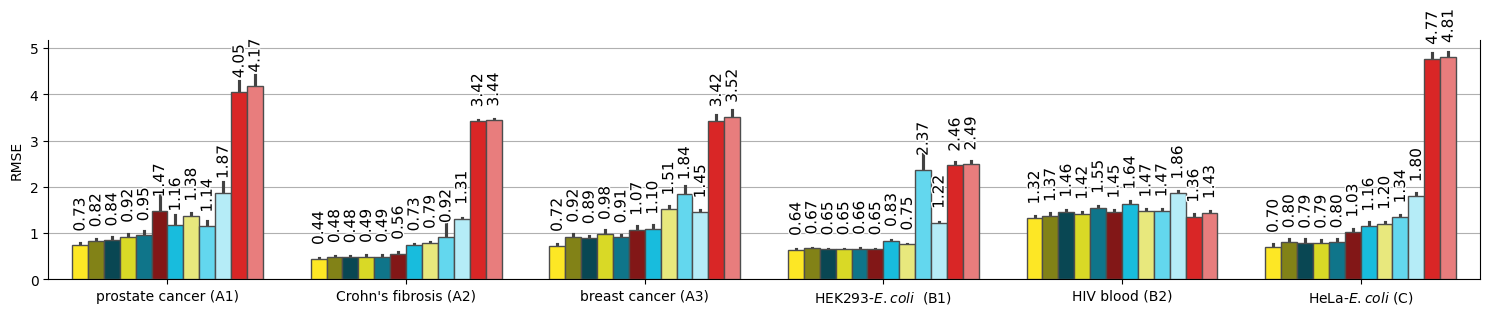

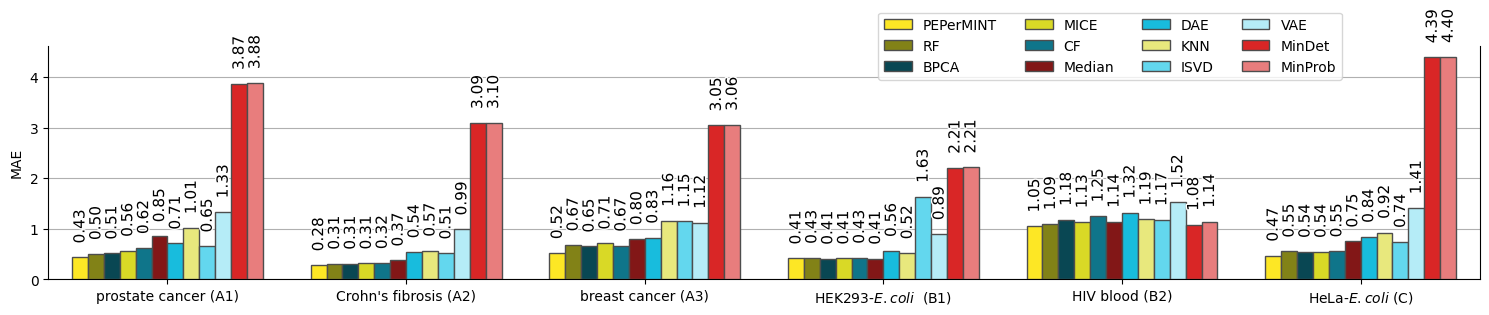

In [13]:
import matplotlib.patheffects as PathEffects

for df, ylabel, fig_name in [(rmse_dfs.copy(), 'RMSE', 'sample_wise_rmse_bar'), (mae_dfs.copy(), 'MAE', 'dataset_mae_bar')]:
   fig, ax = plt.subplots(1, 1, figsize=(15, 3.25))
   df['column'] = df['column'].map(method_label_map)
   df['dataset'] = df['dataset'].map(dataset_label_map)
   sns.barplot(df, y='metric', x='dataset', hue='column', ax=ax, hue_order=method_order,  linewidth=1.0, edgecolor="0.3", palette=PALETTE,
               order=[dataset_label_map[d] for d in ["prostate_cancer", "crohns_fibrosis", "breast_cancer", "human_ecoli_ddia", "blood_ddia", "maxlfqbench"]],
               zorder=3, saturation=100)
   ax.set_ylabel(ylabel)
   ax.grid(axis='y', zorder=0)
   ax.spines['top'].set_visible(False)
   for container in ax.containers:
      ax.bar_label(container, fmt='%.2f', label_type='edge', rotation = 90, padding=10, fontsize=11, path_effects=[PathEffects.withStroke(linewidth=2, foreground='w')])#15.1)
   ticks = [k.get_text() for k  in ax.get_xticklabels()]
   ax.set_xticks(ax.get_xticks()) # Workaround to silence a warning
   ax.set_xticklabels(ticks, ha='center')
   ax.legend(loc='lower left', bbox_to_anchor=(0.575, 0.825), ncol=4, fontsize=10)
   if fig_name == 'sample_wise_rmse_bar':
      ax.legend().remove()
   ax.set_xlabel('')
   fig.tight_layout()
   fig.savefig(f'figures/{fig_name}.pdf')

## Performance across Missingness Thresholds

In [8]:
thresh_rmse_dfs = dict()
intervals = [(1.0, 0.75), (0.75, 0.5), (0.5, 0.25), (0.25, 0.0)]
with tqdm(total=len(imp_datasets) * len(intervals)) as pbar:
    for ds_name, ds in imp_datasets.items():
        rmse_df = []
        for inter in intervals:
            ids = ds.values['peptide']['abundance_gt']
            ids = ids[~ids.isna() & ds.values['peptide']['abundance'].isna()].index
            missingness = ds.get_wf('peptide', 'abundance')
            missingness = missingness[(missingness.isna().sum(axis=1) / missingness.shape[1] <= inter[0]) & 
                                      (missingness.isna().sum(axis=1) / missingness.shape[1] >= inter[1])].index
            ids = ids[ids.get_level_values('id').isin(missingness)]
            metric_df = compare_columns(dataset=ds, molecule='peptide', columns=eval_columns, comparison_column=gt_column,
                                        metric='RMSE', logarithmize=False, ids=ids, per_sample=True, ignore_missing=False)
            metric_df['interval_lower'] = inter[1]
            metric_df['interval_upper'] = inter[0]
            rmse_df.append(metric_df)
            pbar.update(1)
        rmse_df= pd.concat(rmse_df)
        thresh_rmse_dfs[ds_name] = rmse_df

  0%|          | 0/24 [00:00<?, ?it/s]

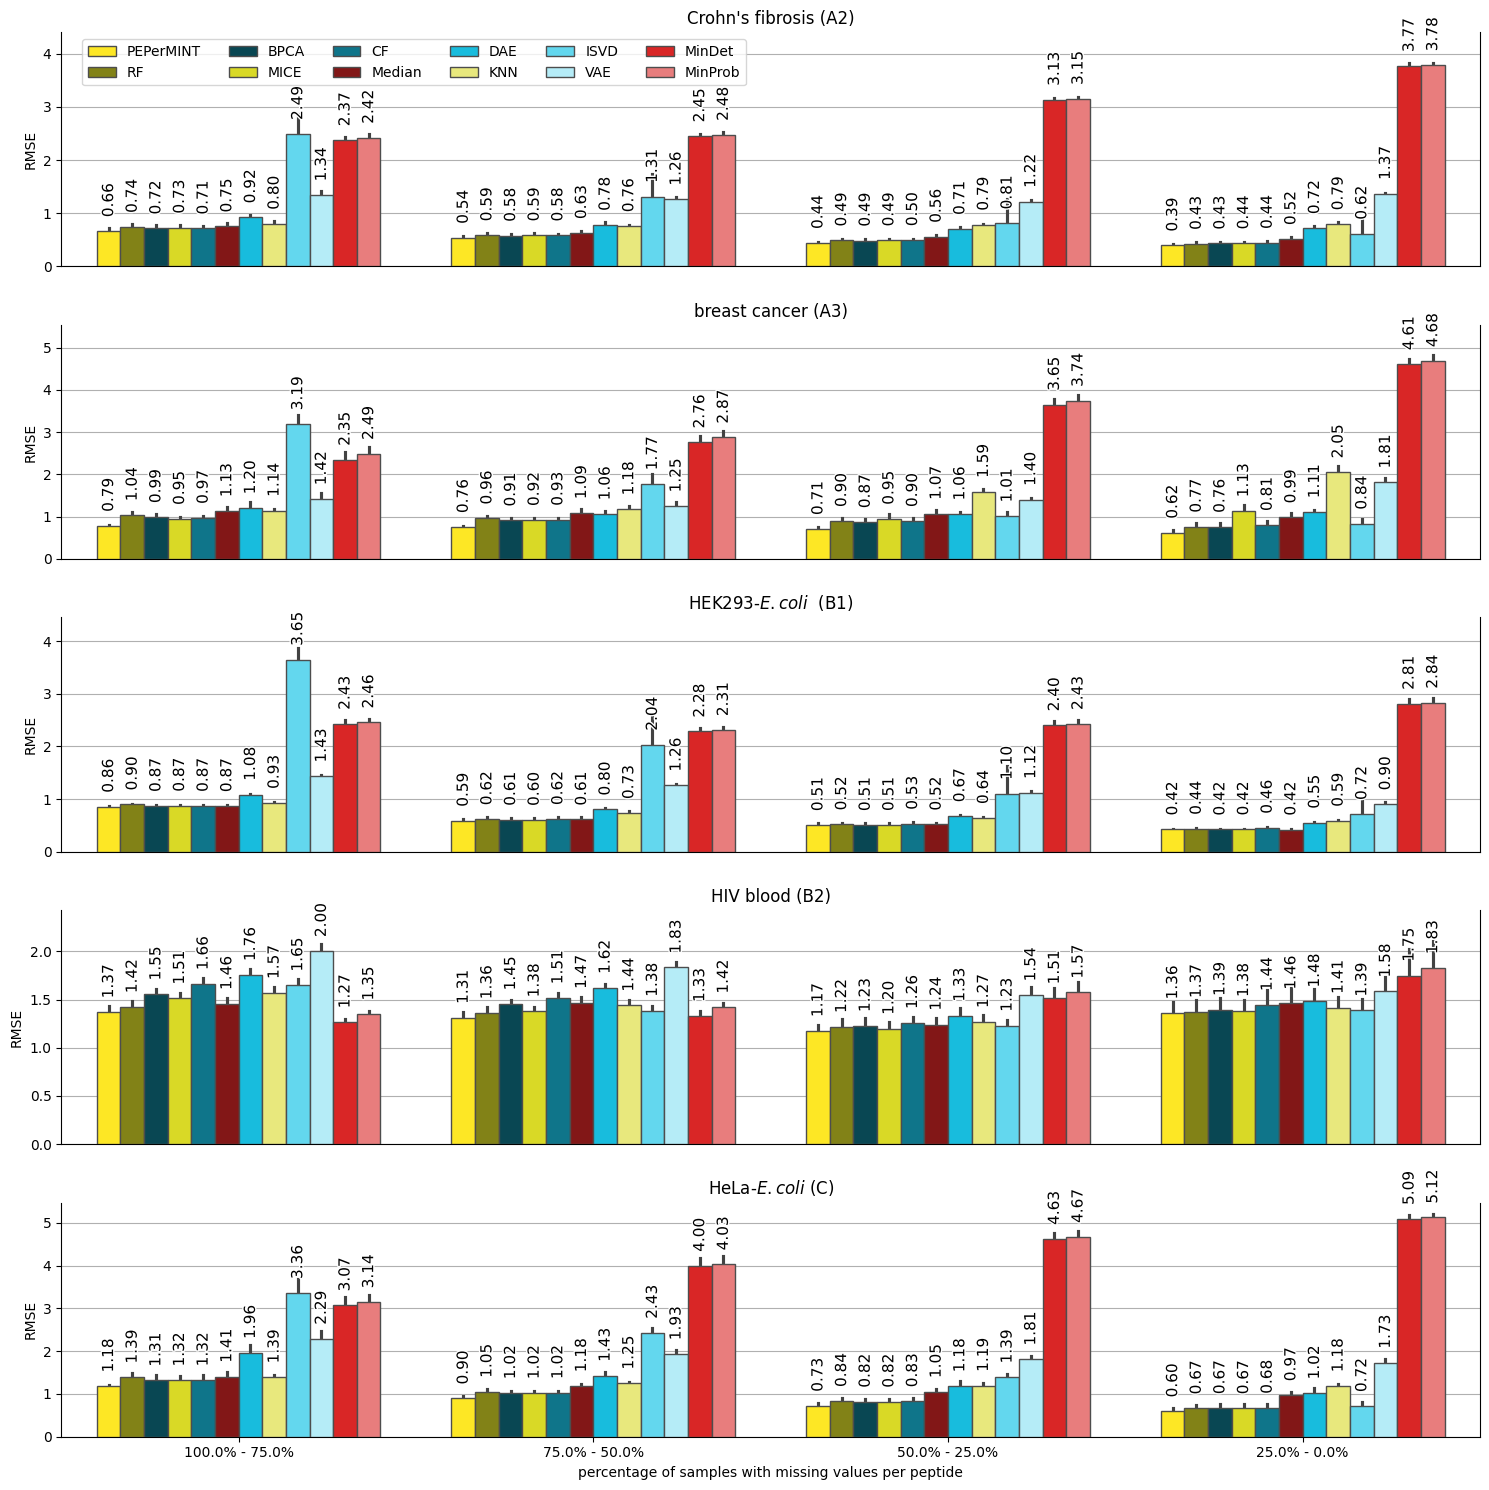

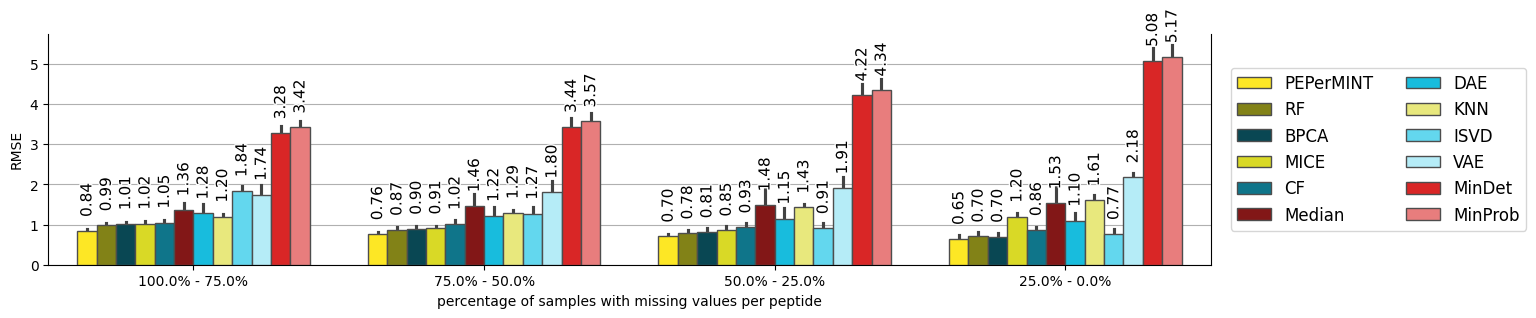

In [9]:
from matplotlib import patheffects as PathEffects

ds_names = ['prostate_cancer', 'crohns_fibrosis', 'breast_cancer', 'human_ecoli_ddia', 'blood_ddia', 'maxlfqbench']

num_rows = len(ds_names) - 1
fig, axs = plt.subplots(num_rows, 1, figsize=(15, 3*num_rows))
fig_main, ax_main = plt.subplots(1, 1, figsize=(15, 3))
col = -1
for ds_name in ds_names:
   ds = imp_datasets[ds_name]
   df = thresh_rmse_dfs[ds_name].copy()
   if ds_name == 'prostate_cancer':
      ax = ax_main
   else:
      col += 1
      ax = axs[col]
   df['column'] = df['column'].map(method_label_map)
   df['interval'] = (df['interval_upper']*100).astype(str) + '% - ' + (df['interval_lower']*100).astype(str) + '%'
   sns.barplot(df, y='metric', x='interval', hue='column', ax=ax, hue_order=method_order,  linewidth=1.0, edgecolor="0.3",
               palette=PALETTE, zorder=10, saturation=100)
   ax.set_ylabel('RMSE')
   for container in ax.containers:
      ax.bar_label(container, fmt='%.2f', label_type='edge', rotation = 90, padding=10,
                    fontsize=11, path_effects=[PathEffects.withStroke(linewidth=2, foreground='w')])#15.1)
   ticks = [k.get_text() for k  in ax.get_xticklabels()]
   ax.grid(axis='y', zorder=1)
   ax.spines['top'].set_visible(False)
   ax.set_xticks(ax.get_xticks()) # Workaround to silence a warning
   ax.set_xticklabels(ticks, ha='center')
   ax.set_xlabel('percentage of samples with missing values per peptide')
   ax.set_title(dataset_label_map[ds_name])
   if ds_name == 'prostate_cancer':
      ax.set_title('')
   if col==0 and ds_name != 'prostate_cancer':
      ax.legend(loc='upper left', bbox_to_anchor=(0.01, 1.0), ncol=6, fontsize=10)
   elif ds_name == 'prostate_cancer':
       ax.legend(loc='center left', bbox_to_anchor=(1.01, 0.5), ncol=2, fontsize=12)
   else:
      ax.legend().remove()
   if col<len(ds_names)-2 and ds_name != 'prostate_cancer':
      ax.set_xticks([])
      ax.set_xlabel('')
      ax.margins(y=0.15) 
fig.tight_layout()
fig.savefig(f'figures/sample_wise_rmse_bar_stratified_supplement.pdf', bbox_inches='tight')
fig_main.savefig(f'figures/sample_wise_rmse_bar_stratified_main.pdf', bbox_inches='tight')

## Wilcoxon Matrix

In [7]:
#Generate the Wilcoxon signed-rank test matrices
intervals = [(1.0, 0.0), (1.0, 0.75), (0.75, 0.5), (0.5, 0.25), (0.25, 0.0)]
wilcoxon_results = {}

with tqdm(total=len(imp_datasets) * len(intervals)) as pbar:
    for ds_name, ds in imp_datasets.items():
        wilcoxon_results[ds_name] = {}
        for inter in intervals:
            gt_column = 'abundance_gt'
            ids = ds.values['peptide']['abundance_gt']
            ids = ids[~ids.isna() & ds.values['peptide']['abundance'].isna()].index
            missingness = ds.get_wf('peptide', 'abundance')
            missingness = missingness[(missingness.isna().sum(axis=1) / missingness.shape[1] <= inter[0]) & 
                                      (missingness.isna().sum(axis=1) / missingness.shape[1] >= inter[1])].index
            ids = ids[ids.get_level_values('id').isin(missingness)]
            mat = paired_wilcoxon_matrix(dataset=ds, molecule='peptide', eval_columns=eval_columns, gt_column=gt_column, ax=None, ids=ids)
            wilcoxon_results[ds_name][inter] = mat
            pbar.update(1)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

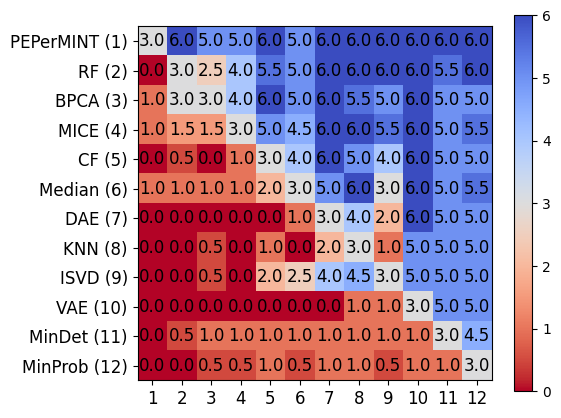

In [17]:
res_mats = {}
res_mat = np.zeros_like(list(wilcoxon_results.values())[0][(1.0, 0.0)][0], dtype=float)

significance_level = 0.05
for ds_name, measure in wilcoxon_results.items():
    if ds_name not in EVAL_DATASETS:
        continue
    results_less, results_greater = measure[(1.0, 0.0)]
    results_less.rename(columns=method_label_map, index=method_label_map, inplace=True)
    results_greater.rename(columns=method_label_map, index=method_label_map, inplace=True)
    results_less = results_less.loc[method_order, method_order]
    results_greater = results_greater.loc[method_order, method_order]
    vec_fun = np.vectorize(lambda x: x.pvalue if x is not None else 0.5)
    pvalues_less = vec_fun(results_less)
    pvalues_greater = vec_fun(results_greater)
    sl = significance_level
    sl = sl / (len(eval_columns)**2 - len(eval_columns))
    res_mat[pvalues_less < sl] += 1
    res_mat[(pvalues_less >= sl) & (pvalues_greater >= 0.05)] += 0.5
fig, ax = plt.subplots(1,1, figsize=(6, 6))
mappable = ax.matshow(res_mat, cmap=matplotlib.cm.coolwarm.reversed())
ax.set_xticks(range(len(method_order)))
ax.set_xticklabels([i+1 for i,m in enumerate(method_order)], rotation=0, ha='center', fontsize=12)
ax.xaxis.set_ticks_position('bottom')
ax.set_yticks(range(len(method_order)))
ax.set_yticklabels([f'{m} ({i+1})' for i,m in enumerate(method_order)], rotation=0, fontsize=12)
for (i, j), z in np.ndenumerate(res_mat):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center', fontsize=12)
ax.grid(False)
fig.colorbar(mappable, shrink=0.66)
fig.tight_layout()
fig.savefig('figures/wilcoxon_matrix.pdf', bbox_inches='tight')

/tmp/ipykernel_1197927/677753824.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


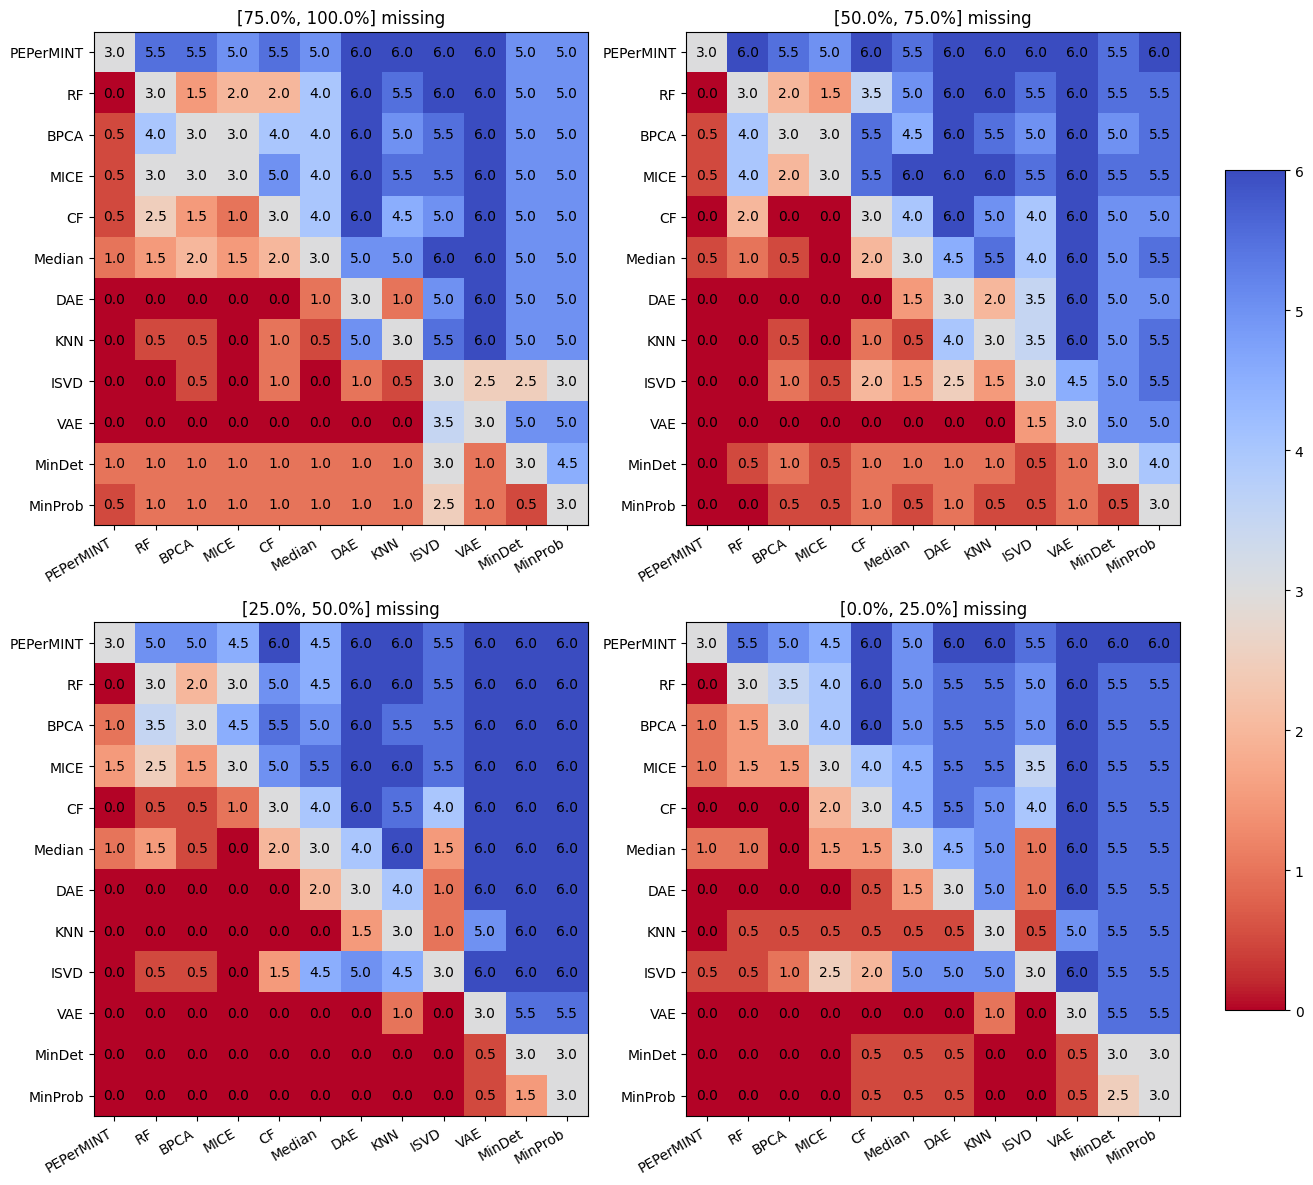

In [24]:
res_mats = {}
for thresh, measures in list(wilcoxon_results.values())[0].items():
    if thresh == (1.0, 0.0):
        continue
    res_mats[thresh] = np.zeros_like(measures[0], dtype=float)

significance_level = 0.05
for ds_name, measures in wilcoxon_results.items():
    if ds_name not in EVAL_DATASETS:
        continue
    for thresh, measure in measures.items():
        if thresh == (1.0, 0.0):
            continue
        results_less, results_greater = measure
        results_less.rename(columns=method_label_map, index=method_label_map, inplace=True)
        results_greater.rename(columns=method_label_map, index=method_label_map, inplace=True)
        results_less = results_less.loc[method_order, method_order]
        results_greater = results_greater.loc[method_order, method_order]
        vec_fun = np.vectorize(lambda x: x.pvalue if x is not None else 0.5)
        pvalues_less = vec_fun(results_less)
        pvalues_greater = vec_fun(results_greater)
        sl = significance_level
        sl = sl / (len(eval_columns)**2 - len(eval_columns))
        res_mats[thresh][pvalues_less < sl] += 1
        res_mats[thresh][(pvalues_less >= sl) & (pvalues_greater >= 0.05)] += 0.5
import math
rows = 2
cols = math.ceil(len(res_mats) / rows)
fig, axs = plt.subplots(rows,cols, figsize=(cols * 6, rows * 6))
axs = axs.flatten()
for ax, (thresh, res_mat) in zip(axs, res_mats.items()):
    mapppable = ax.matshow(res_mat, cmap=matplotlib.cm.coolwarm.reversed())
    ax.set_xticks(range(len(method_order)))
    ax.set_xticklabels([m for m in method_order], rotation=30, ha='right')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_yticks(range(len(method_order)))
    ax.set_yticklabels([m for m in method_order], rotation=0)
    for (i, j), z in np.ndenumerate(res_mat):
        ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
    ax.grid(False)
    ax.set_title(f'[{thresh[1] * 100}%, {thresh[0] * 100}%] missing')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([1.025, 0.15, 0.05, 0.7])
fig.colorbar(mappable=mappable, cax=cbar_ax)
fig.tight_layout()
fig.savefig('figures/wilcoxon_matrix_stratified.pdf', bbox_inches='tight')

## Scatter Plots

gnn_imp
0.6367403190030742
0.4137797367640254
SpearmanrResult(correlation=0.8770040639393645, pvalue=0.0)
median
0.6482204794685353
0.4094059708786214
SpearmanrResult(correlation=0.8661699776896556, pvalue=0.0)
bpca
0.6456091487758046
0.4081236765767555
SpearmanrResult(correlation=0.8676431930082562, pvalue=0.0)
iterative
0.6485113850617427
0.411796902508479
SpearmanrResult(correlation=0.8686646033851797, pvalue=0.0)


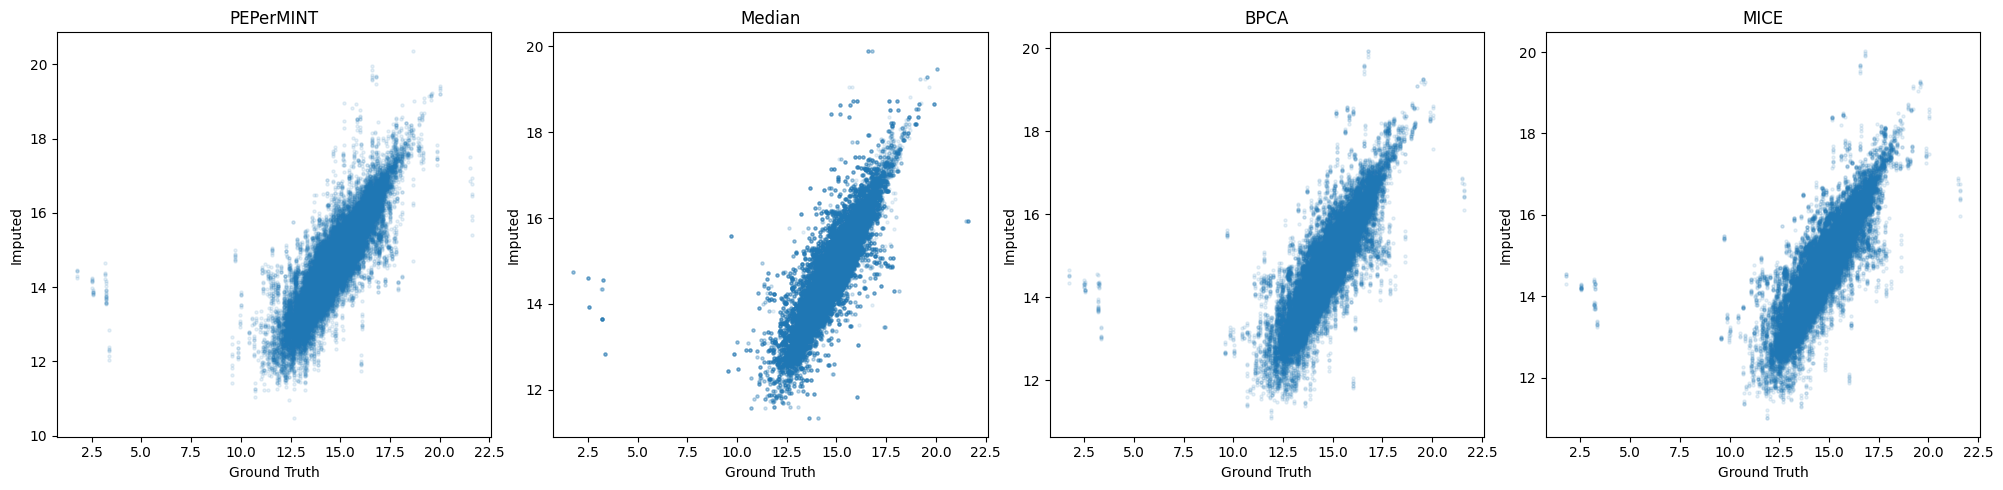

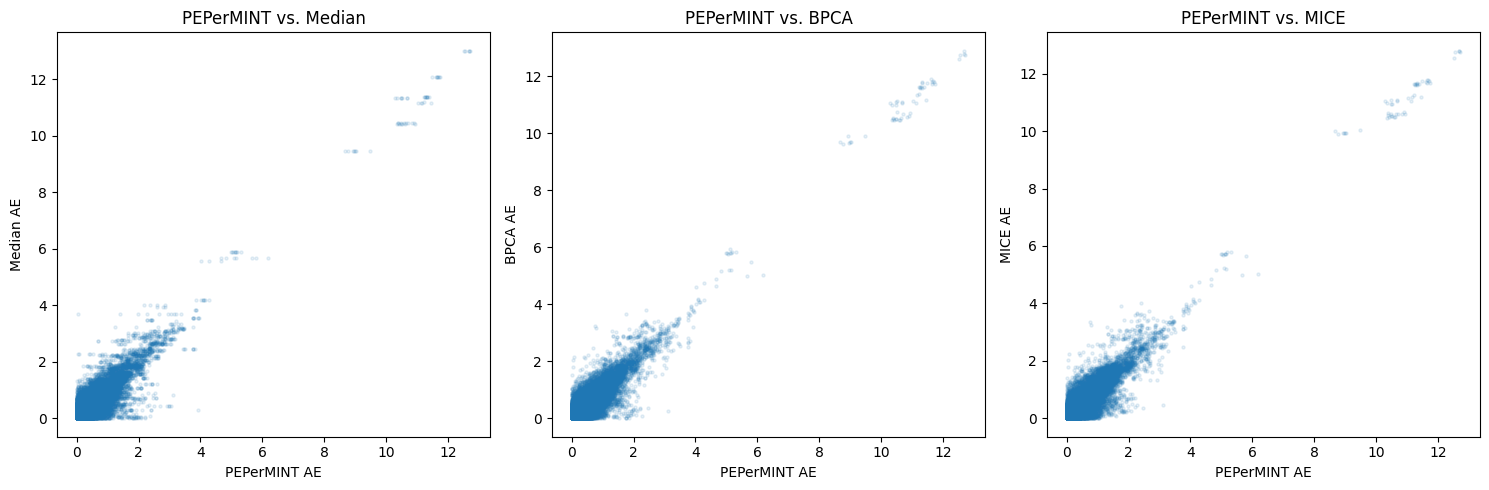

In [102]:
from mpl_scatter_density import ScatterDensityArtist
from scipy.stats import pearsonr, spearmanr

ds = imp_datasets['human_ecoli_ddia']

methods = ['gnn_imp', 'median', 'bpca', 'iterative']
ids = ds.values['peptide']['abundance_gt']
ids = ids[(~ids.isna()) & (ds.values['peptide']['abundance'].isna())].index

fig, axs = plt.subplots(1, len(methods), figsize=(len(methods) * 5, 5))
for m, ax in zip(methods, axs):
    df = ds.values['peptide'].df[['abundance_gt', m]]
    df = df.loc[ids]
    ax.scatter(df.abundance_gt, df[m], s=5, alpha=0.1)
    ax.set_xlabel('Ground Truth')
    ax.set_ylabel('Imputed')
    ax.set_title(method_label_map[m])
fig.tight_layout()
fig.savefig('figures/human_ecoli_selected_abundance_scatter.png', bbox_inches='tight')

fig, axs = plt.subplots(1, (len(methods)-1), figsize=((len(methods)-1) * 5, 5))
for m1 in ['gnn_imp']:
    for m2, ax in zip(['median', 'bpca', 'iterative'], axs):
        df = ds.values['peptide'].df[['abundance_gt', m1, m2]]
        df = df.loc[ids]
        ax.scatter((df[m1]-df['abundance_gt']).abs(), (df[m2]-df['abundance_gt']).abs(), s=5, alpha=0.1)
        ax.set_xlabel(f'{method_label_map[m1]} AE')
        ax.set_ylabel(f'{method_label_map[m2]} AE')
        ax.set_title(f'{method_label_map[m1]} vs. {method_label_map[m2]}')
fig.tight_layout()
fig.savefig('figures/human_ecoli_selected_ae_scatter.png', bbox_inches='tight')

## Differential Expressions

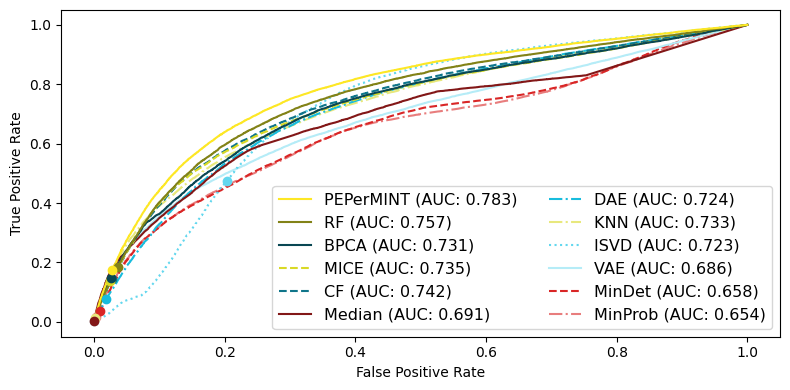

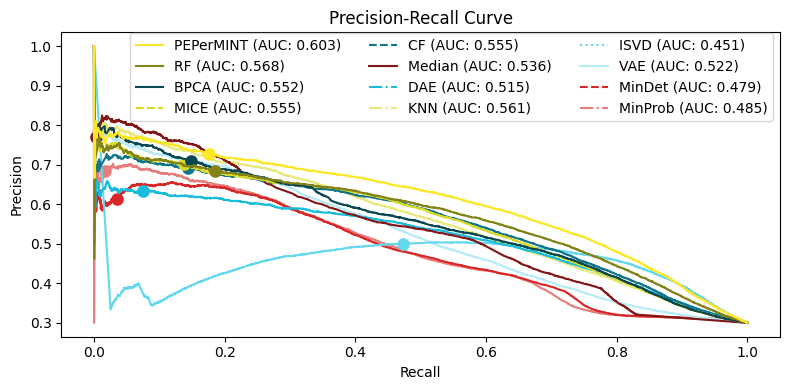

In [17]:
from matplotlib import cm

ds = imp_datasets['maxlfqbench']

numerator_samples = ['H1','H2','H3']
denominator_samples = ['L1','L2','L3']
fc_thresh = 1.5

mols = ds.molecules['peptide']
ids = mols.loc[(mols.is_ecoli.astype(int) + mols.is_human.astype(int)) == 1].index

des, pvalues, fc = find_des(dataset=ds, molecule='peptide', columns=eval_columns,
                            nominator_samples=numerator_samples, denominator_samples=denominator_samples,
                            min_fc=1, max_pvalue=0.05, is_log=True, assume_equal_var=False)
is_ecoli = ds.molecules['peptide'].is_ecoli
pvalues = pvalues.loc[ids]
is_ecoli = is_ecoli.loc[ids]
categories = pd.Series(index=is_ecoli.index, data='')
categories.loc[is_ecoli] = 'E. coli'
categories.loc[~is_ecoli] = 'Human'
gt_fc = pd.Series(index=categories.index, data=1)
gt_fc.loc[categories == 'E. coli'] = 3
gt_fc[gt_fc == 1] = 0
gt_fc[gt_fc == 3] = 1

from sklearn.metrics import precision_recall_curve, roc_curve, auc
line_types = ['-', '-', '-', '--', '--', '-', '-.', '-.', ':', '-', '--', '-.']


fig_roc, ax_roc = plt.subplots(1, 1, figsize=(8, 4))
fig_prc, ax_prc = plt.subplots(1, 1, figsize=(8, 4))
pvalues = pvalues.rename(columns=method_label_map)
prauc_values = {}
roc_values = {}
for column, color, line_type, i in zip(method_order, PALETTE, line_types, np.arange(len(method_order))):
    ax = ax_prc
    precision, recall, thresholds = precision_recall_curve(y_true=gt_fc, probas_pred=1 - pvalues[column])
    tmp = thresholds
    for fdr, marker in zip([0.05], ['o', 'x']):#for fdr, marker in zip([0.05, 0.1], ['o', 'x']):
        fdr_coords = np.argmax(thresholds >= (1 - fdr))
        fdr_coords = (recall[fdr_coords], precision[fdr_coords])
        ax.scatter([fdr_coords[0]], [fdr_coords[1]], marker=marker, s=50, color=color, zorder=1000-i, linewidth=2)
    ax.plot(recall, precision, label=column, color=color,  zorder=1000-i)
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    a = auc(recall, precision)
    prauc_values[column] = a

    ax = ax_roc
    fpr, tpr, thresholds = roc_curve(y_true=gt_fc, y_score=1 - pvalues[column])
    ax.plot(fpr, tpr, label=column, color=color, linestyle=line_type, zorder=100-i)
    for fdr, marker in zip([0.05], ['o', 'x']):#for fdr, marker in zip([0.05, 0.1], ['o', 'x']):
        fdr_coords = np.argmax(thresholds < (1 - fdr)) - 1
        fdr_coords = (fpr[fdr_coords], tpr[fdr_coords])
        ax.scatter([fdr_coords[0]], [fdr_coords[1]], marker=marker, s=25, color=color, zorder=1000-i, linewidth=2)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    a = auc(fpr, tpr)
    roc_values[column] = a
handles, labels = ax.get_legend_handles_labels()
ax_prc.legend(handles, [f'{l} (AUC: {prauc_values[l]:.3f})' for l in labels], loc='upper right', ncol=3, bbox_to_anchor=(1.0, 1.02), fontsize=10)
ax_prc.set_title('Precision-Recall Curve')
ax_roc.legend(handles, [f'{l} (AUC: {roc_values[l]:.3f})' for l in labels], loc='lower right', ncol=2, bbox_to_anchor=(1.0, 0.0), fontsize=11.5)
#ax_roc.set_title('ROC Curve')
fig_roc.tight_layout()
fig_roc.savefig(f'figures/de_roc_fdr.pdf', bbox_inches='tight')
fig_prc.tight_layout()
fig_prc.savefig(f'figures/de_prc_fdr.pdf', bbox_inches='tight')

## Uncertainty

/tmp/ipykernel_1182802/1627993821.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/tmp/ipykernel_1182802/1627993821.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/tmp/ipykernel_1182802/1627993821.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


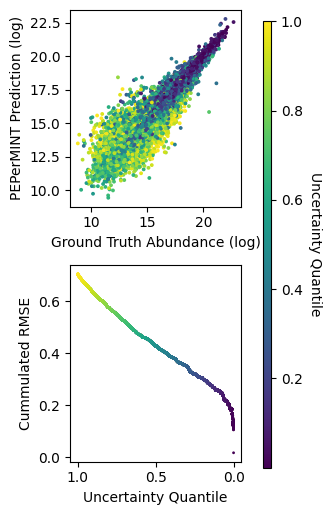

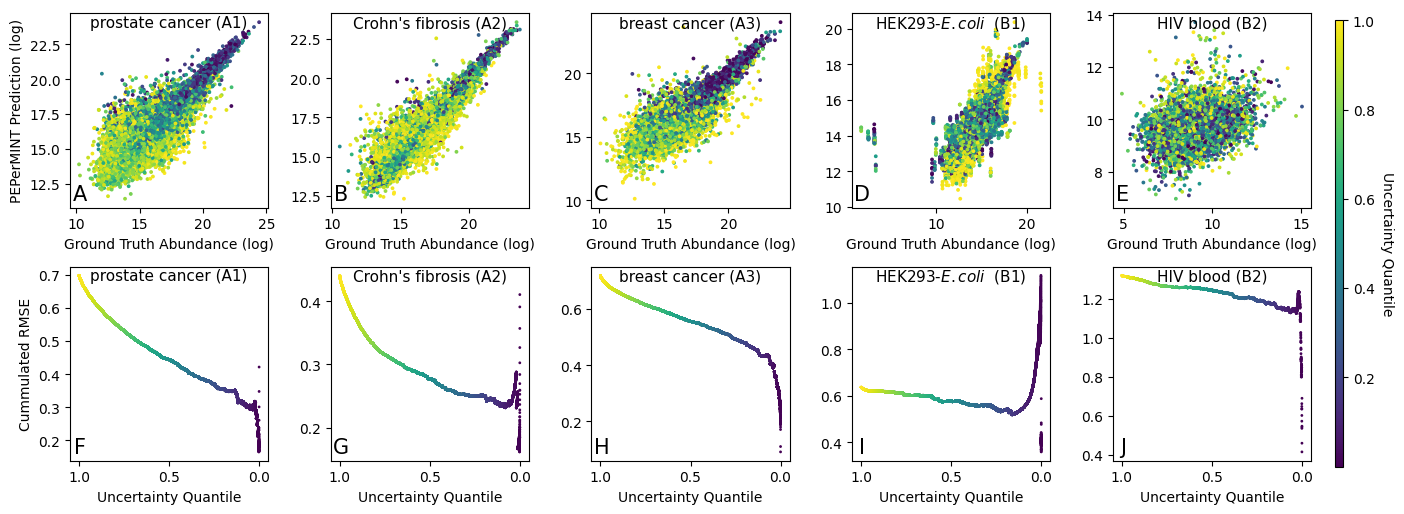

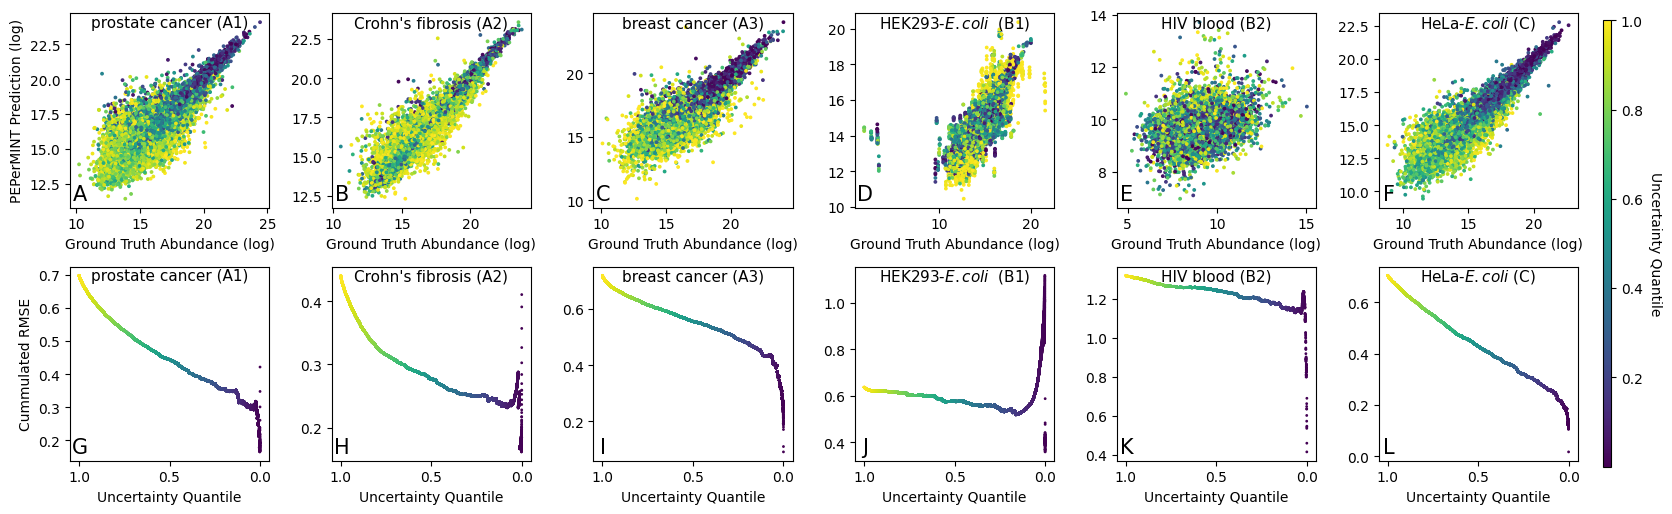

In [19]:
import pandas as pd
from matplotlib import pyplot as plt

main_uncertainty_datasets = ['prostate_cancer', 'crohns_fibrosis', 'breast_cancer']
ratio_uncertainty_datasts = ['maxlfqbench']
supplementary_uncertainty_datasets = ['prostate_cancer', 'crohns_fibrosis', 'breast_cancer', 'human_ecoli_ddia', 'blood_ddia']
all_uncertainty_datasets = ['prostate_cancer', 'crohns_fibrosis', 'breast_cancer', 'human_ecoli_ddia', 'blood_ddia', 'maxlfqbench']
letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L']
for ds_names, label in [(ratio_uncertainty_datasts, 'main'), (supplementary_uncertainty_datasets, 'supplementary'),
                        (all_uncertainty_datasets, 'all')]:
    fig, axs = plt.subplots(2, len(ds_names), figsize=(8/3 * len(ds_names), 5.25))
    axs = axs.flatten()
    for i, ds_name in enumerate(ds_names):
        ds = imp_datasets[ds_name]
        df = ds.values['peptide'].df
        gt_column = 'abundance_gt'
        gt =df[gt_column]
        mask = df['abundance'].isna() &  ~gt.isna()
        gt = gt[mask]
        gnn = df[f'gnn_imp']
        gnn = gnn[mask]
        uncertainty = df[f'gnn_imp_var']
        uncertainty = uncertainty[mask]
        diff = (gt - gnn).abs()
        se  = (gt - gnn)**2
        df = pd.DataFrame({'gt':gt, 'gnn':gnn, 'ae':diff, 'se':se, 'uncertainty':uncertainty})
        df['ae_rank'] = df.ae.rank()
        df['uncertainty_rank'] = df.uncertainty.rank() / df.shape[0]
        ax = axs[i]
        mappable = ax.scatter(gt, gnn, c=df.uncertainty_rank, s=3)
        if label != 'main':
            ax.text(0.05, 0.07, letters[i], horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=15)
        ax.set_xlabel('Ground Truth Abundance (log)')
        if label != 'main':
            ax.set_title(f'{dataset_label_map[ds_name]}', x=0.5, y=0.885, fontsize=11)
        if i == 0:
            ax.set_ylabel('PEPerMINT Prediction (log)')
        ax = axs[len(ds_names) + i]
        if label != 'main':
            ax.text(0.05, 0.07, letters[len(ds_names) + i], horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=15)
        df = df.sort_values('uncertainty', ascending=True)
        df['mae'] = df['ae'].cumsum() / np.arange(1, df.shape[0] + 1)
        df['mse'] = df['se'].cumsum() / np.arange(1, df.shape[0] + 1)
        df['rmse'] = np.sqrt(df['mse'])
        ax.scatter(df.uncertainty_rank, df['rmse'], s=1, c=df.uncertainty_rank)
        ax.set_xlim(ax.get_xlim()[::-1])
        #ax.scatter(df['ae'], np.log(df['uncertainty']), s=1)
        ax.set_xlabel('Uncertainty Quantile')
        if label != 'main':
            ax.set_title(f'{dataset_label_map[ds_name]}', x=0.5, y=0.885, fontsize=11)
        if i == 0:
            ax.set_ylabel('Cummulated RMSE')
    fig.subplots_adjust(right=0.95)
    cbar_ax = fig.add_axes([1.005, 0.1, 0.03 / len(ds_names), 0.85])
    cbar = fig.colorbar(mappable=mappable, cax=cbar_ax)
    cbar.set_label('Uncertainty Quantile', rotation=-90, verticalalignment='bottom')
    fig.tight_layout()
    fig.savefig(f'figures/uncertainty_{label}.png', bbox_inches='tight')

(18165,)
(27616,)
(33577,)
(38001,)
(43101,)
(50260,)
(0.0005119453924914676, 0.003783604381015599)
(18165,)
(27616,)
(33577,)
(38001,)
(43101,)
(50260,)
(0.0005119453924914676, 0.003783604381015599)


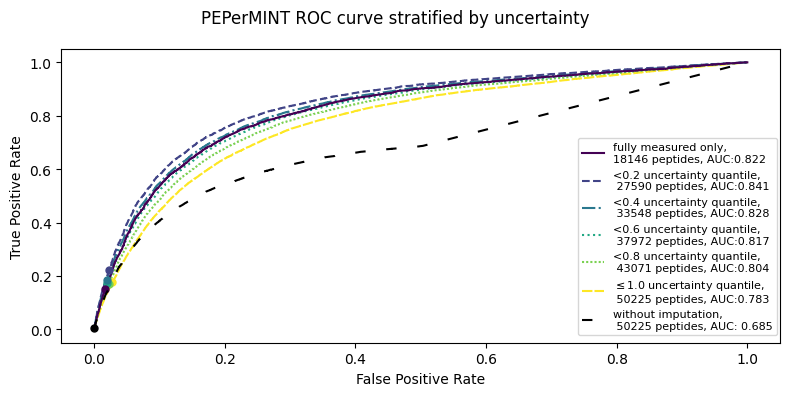

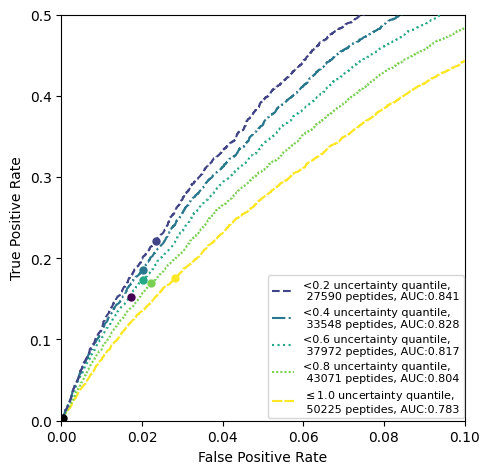

In [9]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from matplotlib.cm import tab10
from matplotlib.cm import viridis

line_types = ['solid', '--', '-.', ':', (0, (1, 1)), (0, (5, 1))]

ds = imp_datasets['maxlfqbench']

numerator_samples = ['H1','H2','H3']
denominator_samples = ['L1','L2','L3']
fc_thresh = 1.5

for is_zoomed in [False, True]:
    if is_zoomed:
        fig_roc, ax_roc = plt.subplots(1, 1, figsize=(5, 5))
    else:
        fig_roc, ax_roc = plt.subplots(1, 1, figsize=(8, 4))
    for i, (quantile, color) in enumerate(zip([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], tab10.colors)):
        ds = imp_datasets['maxlfqbench'].copy()
        var = ds.values['peptide'].df['gnn_imp_var']
        var.mean(), var.std()
        mat = ds.get_wf('peptide', 'gnn_imp')
        var_mat = ds.get_wf('peptide', 'gnn_imp_var')
        var_mat[var_mat.isna()] = 0
        thresh = var.quantile(quantile)
        if quantile == 1.0:
            ids = (var_mat <= thresh).all(axis=1)
        else:
            ids = (var_mat < thresh).all(axis=1)
        ids = ids[ids].index
        print(ids.shape)
        mols = ds.molecules['peptide']
        ids = ids.intersection(mols.loc[(mols.is_ecoli.astype(int) + mols.is_human.astype(int)) == 1].index)

        des, pvalues, fc = find_des(dataset=ds, molecule='peptide', columns=['gnn_imp'],
                                    nominator_samples=numerator_samples, denominator_samples=denominator_samples,
                                    min_fc=1, max_pvalue=0.05, is_log=True, assume_equal_var=False, ids=ids)
        is_ecoli = ds.molecules['peptide'].is_ecoli
        pvalues = pvalues.loc[ids]
        is_ecoli = is_ecoli.loc[ids]
        categories = pd.Series(index=is_ecoli.index, data='')
        categories.loc[is_ecoli] = 'E. coli'
        categories.loc[~is_ecoli] = 'Human'
        gt_fc = pd.Series(index=categories.index, data=1)
        gt_fc.loc[categories == 'E. coli'] = 3
        gt_fc[gt_fc == 1] = 0
        gt_fc[gt_fc == 3] = 1
        ax = ax_roc
        fpr, tpr, thresholds = roc_curve(y_true=gt_fc, y_score=1 - pvalues['gnn_imp'])
        color = viridis(quantile)
        for fdr, marker in zip([0.05], ['o', 'x']):#for fdr, marker in zip([0.05, 0.1], ['o', 'x']):
            fdr_coords = np.argmax(thresholds < (1 - fdr)) - 1
            fdr_coords = (fpr[fdr_coords], tpr[fdr_coords])
            ax.plot([fdr_coords[0]], [fdr_coords[1]], marker=marker, markersize=5, color=color, zorder=1000-i)
        a = auc(fpr, tpr)
        leq = "$\leq$"
        if quantile == 0.0:
            l = f'fully measured only,\n{ids.shape[0]} peptides, AUC:{a:.3f}'
        else:
            l = f'{leq if quantile==1.0 else "<" }{quantile} uncertainty quantile,\n {ids.shape[0]} peptides, AUC:{a:.3f}'
        if not (is_zoomed and quantile == 0.0):
            ax.plot(fpr, tpr, label=l, color=color, zorder=100-i, linestyle=line_types[i])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')

    mols = ds.molecules['peptide']
    ids = mols.loc[(mols.is_ecoli.astype(int) + mols.is_human.astype(int)) == 1].index
    des, pvalues, fc = find_des(dataset=ds, molecule='peptide', columns=['abundance'],
                                nominator_samples=numerator_samples, denominator_samples=denominator_samples,
                                min_fc=1, max_pvalue=0.05, is_log=True, assume_equal_var=False, ids=ids)
    is_ecoli = ds.molecules['peptide'].is_ecoli
    pvalues = pvalues.loc[ids]
    is_ecoli = is_ecoli.loc[ids]
    categories = pd.Series(index=is_ecoli.index, data='')
    categories.loc[is_ecoli] = 'E. coli'
    categories.loc[~is_ecoli] = 'Human'
    gt_fc = pd.Series(index=categories.index, data=1)
    gt_fc.loc[categories == 'E. coli'] = 3
    gt_fc[gt_fc == 1] = 0
    gt_fc[gt_fc == 3] = 1
    ax = ax_roc
    fpr, tpr, thresholds = roc_curve(y_true=gt_fc, y_score=1 - pvalues['abundance'])
    fdr_coords = np.argmax(thresholds < (1 - fdr)) - 1
    fdr_coords = (fpr[fdr_coords], tpr[fdr_coords])
    for fdr, marker in zip([0.05], ['o', 'x']):#for fdr, marker in zip([0.05, 0.1], ['o', 'x']):
        fdr_coords = np.argmax(thresholds < (1 - fdr)) - 1
        fdr_coords = (fpr[fdr_coords], tpr[fdr_coords])
        print(fdr_coords)
        ax.plot([fdr_coords[0]], [fdr_coords[1]], marker=marker, markersize=5, color='black', zorder=1000)
    a = auc(fpr, tpr)
    if not is_zoomed:
        ax.plot(fpr, tpr, label=f'without imputation,\n {ids.shape[0]} peptides, AUC: {a:.3f}', color='black', zorder=1000, linestyle=(0, (5, 10)))

    fig_roc.suptitle('PEPerMINT ROC curve stratified by uncertainty')
    letter = 'A'
    if is_zoomed:
        ax.set_xlim(0, 0.1)
        ax.set_ylim(0, .5)
        fig_roc.suptitle('')#PEPerMINT ROC curve stratified by uncertainty (zoomed)')
        letter = 'B'
        fig_roc.legend(loc='lower right', bbox_to_anchor=(0.95, 0.11), fontsize=8)
    else:
        fig_roc.legend(loc='lower right', bbox_to_anchor=(0.985, 0.15), fontsize=8)
    fig_roc.tight_layout()
    fig_roc.savefig(f'figures/roc_stratified_uncertainty{"_zoomed" if is_zoomed else ""}.pdf', bbox_inches='tight')

## Ablation Study

In [43]:
ablation_datasets = {}
ablation_datasets['prostate_cancer'] = imp_datasets['prostate_cancer'].copy()
ablation_datasets['prostate_cancer_random_edges'] = Dataset.load(f'data/datasets_experiments/prostate_cancer_random_edges')
ablation_datasets['prostate_cancer_zero_sequence_embeddings'] = Dataset.load(f'data/datasets_experiments/prostate_cancer_zero_sequence_embeddings')
ablation_datasets['prostate_cancer_no_skip'] = Dataset.load(f'data/datasets_experiments/prostate_cancer_no_skip')
#ablation_datasets['prostate_cancer_no_skip_random_edges'] = Dataset.load(f'data/datasets_experiments/prostate_cancer_no_skip_random_edges')

In [44]:
ablation_rmse_dfs = []
ablation_mae_dfs = []
with tqdm(total=len(ablation_datasets)) as pbar:
    for ds_name, ds in ablation_datasets.items():
        gt_column = 'abundance_gt'
        ids = ds.values['peptide'][gt_column]
        ids = ids[~ids.isna() & ds.values['peptide']['abundance'].isna()].index
        metric_df = compare_columns(dataset=ds, molecule='peptide', columns=eval_columns, comparison_column=gt_column,
                                    metric='RMSE', logarithmize=False, ids=ids, per_sample=True, ignore_missing=False)
        metric_df['dataset'] = ds_name
        ablation_rmse_dfs.append(metric_df)

        df = ds.values['peptide'].df
        df = df.loc[ids]
        ae = ((df - df[[gt_column]].values).abs())
        ae = ae[eval_columns]
        mae = ae.mean()
        mae_df = pd.DataFrame({'metric':mae})
        mae_df.index.set_names('column', inplace=True)
        mae_df = mae_df.reset_index()
        mae_df['dataset'] = ds_name
        ablation_mae_dfs.append(mae_df)
        pbar.update(1)
ablation_rmse_dfs= pd.concat(ablation_rmse_dfs)
ablation_mae_dfs = pd.concat(ablation_mae_dfs)

  0%|          | 0/4 [00:00<?, ?it/s]

/tmp/ipykernel_1040095/1083628865.py:10: UserWarning: The palette list has more values (12) than needed (4), which may not be intended.
  sns.barplot(df, y='metric', x='dataset', hue='dataset', ax=ax,  linewidth=1.0, edgecolor="0.3", palette=PALETTE, zorder=3, saturation=1.0)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_1040095/1083628865.py:10: UserWarning: The palette list has more values (12) than needed (4), which may not be intended.
  sns.barplot(df, y='metric', x='dataset', hue='dataset', ax=ax,  linewidth=1.0, edgecolor="0.3", palette=PALETTE, zorder=3, saturation=1.0)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


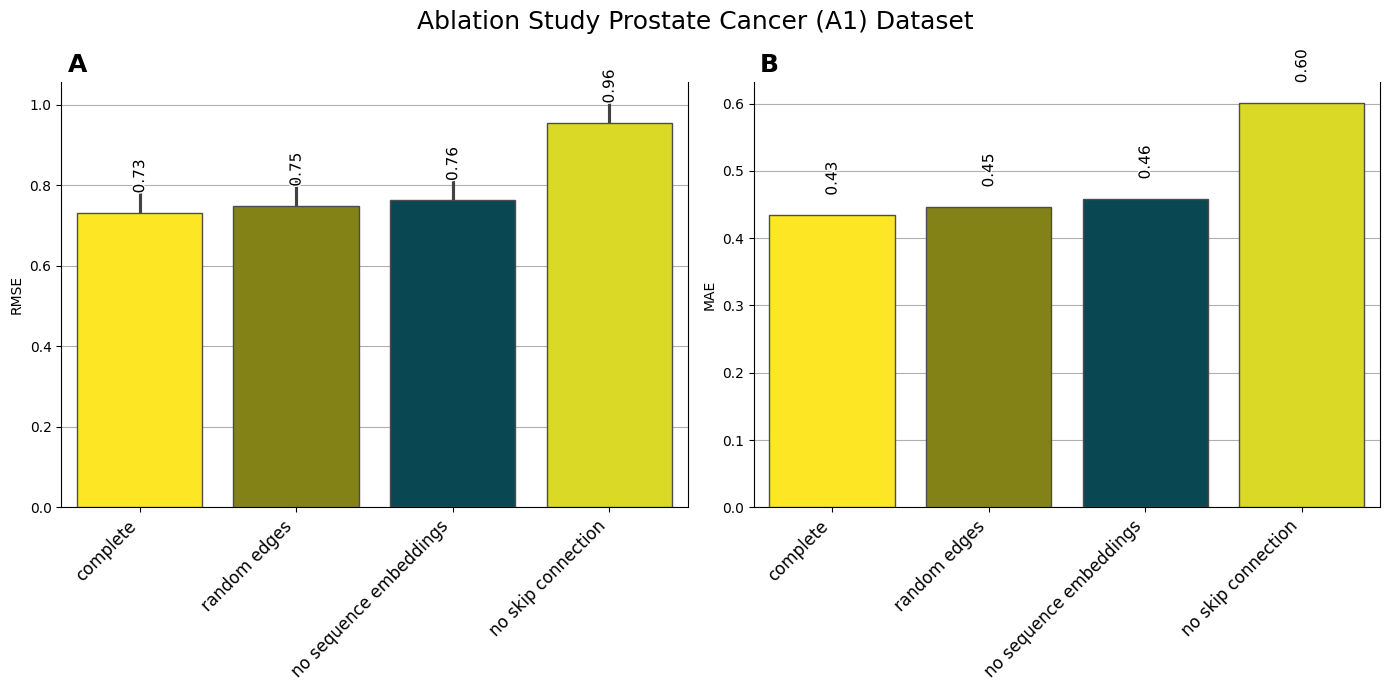

In [57]:
import matplotlib.patheffects as PathEffects


fig, axs = plt.subplots(1, 2, figsize=(14, 7))
for (df, ylabel, fig_name, label), ax in zip([(ablation_rmse_dfs.copy(), 'RMSE', 'sample_wise_rmse_bar', 'A'),
                                              (ablation_mae_dfs.copy(), 'MAE', 'dataset_mae_bar', 'B')], axs):
   df['column'] = df['column'].map(method_label_map)
   df['dataset'] = df['dataset'].map(dataset_label_map)
   df = df[df['column']=='PEPerMINT']
   sns.barplot(df, y='metric', x='dataset', hue='dataset', ax=ax,  linewidth=1.0, edgecolor="0.3", palette=PALETTE, zorder=3, saturation=1.0)
   ax.set_ylabel(ylabel)
   ax.grid(axis='y', zorder=0)
   ax.spines['top'].set_visible(False)
   for container in ax.containers:
      ax.bar_label(container, fmt='%.2f', label_type='edge', rotation = 90, padding=14, fontsize=11,
                    path_effects=[PathEffects.withStroke(linewidth=2, foreground='w')])#15.1)
   ticks = [k.get_text() for k  in ax.get_xticklabels()]
   ax.set_xticks(ax.get_xticks()) # Workaround to silence a warning
   ax.set_xticklabels(['complete', 'random edges', 'no sequence embeddings', 'no skip connection'],# 'no skip connection & random edges'],
                      ha='right', rotation=45, fontsize=12)
   ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.2), ncol=6, fontsize=10).remove()
   ax.set_xlabel('')
   ax.text(s=label, x=0.01, y=1.025, transform=ax.transAxes, fontsize=18, fontweight='bold')
fig.suptitle('Ablation Study Prostate Cancer (A1) Dataset', fontsize=18)
fig.tight_layout()
fig.savefig(f'figures/ablation.pdf')

In [46]:
thresh_rmse_dfs = dict()
intervals = [(1.0, 0.75), (0.75, 0.5), (0.5, 0.25), (0.25, 0.0)]
with tqdm(total=len(ablation_datasets) * len(intervals)) as pbar:
    for ds_name, ds in ablation_datasets.items():
        rmse_df = []
        for inter in intervals:
            ids = ds.values['peptide']['abundance_gt']
            ids = ids[~ids.isna() & ds.values['peptide']['abundance'].isna()].index
            missingness = ds.get_wf('peptide', 'abundance')
            missingness = missingness[(missingness.isna().sum(axis=1) / missingness.shape[1] <= inter[0]) & 
                                      (missingness.isna().sum(axis=1) / missingness.shape[1] >= inter[1])].index
            ids = ids[ids.get_level_values('id').isin(missingness)]
            #print(f'{ds_name}, {inter}, {ids.shape[0]}')
            metric_df = compare_columns(dataset=ds, molecule='peptide', columns=eval_columns, comparison_column=gt_column,
                                        metric='RMSE', logarithmize=False, ids=ids, per_sample=True, ignore_missing=False)
            metric_df['interval_lower'] = inter[1]
            metric_df['interval_upper'] = inter[0]
            rmse_df.append(metric_df)
            pbar.update(1)
        rmse_df= pd.concat(rmse_df)
        thresh_rmse_dfs[ds_name] = rmse_df

  0%|          | 0/16 [00:00<?, ?it/s]

/tmp/ipykernel_1040095/2660976772.py:24: UserWarning: The palette list has more values (12) than needed (4), which may not be intended.
  sns.barplot(all_dfs, y='metric', x='interval', hue='kind', ax=ax,


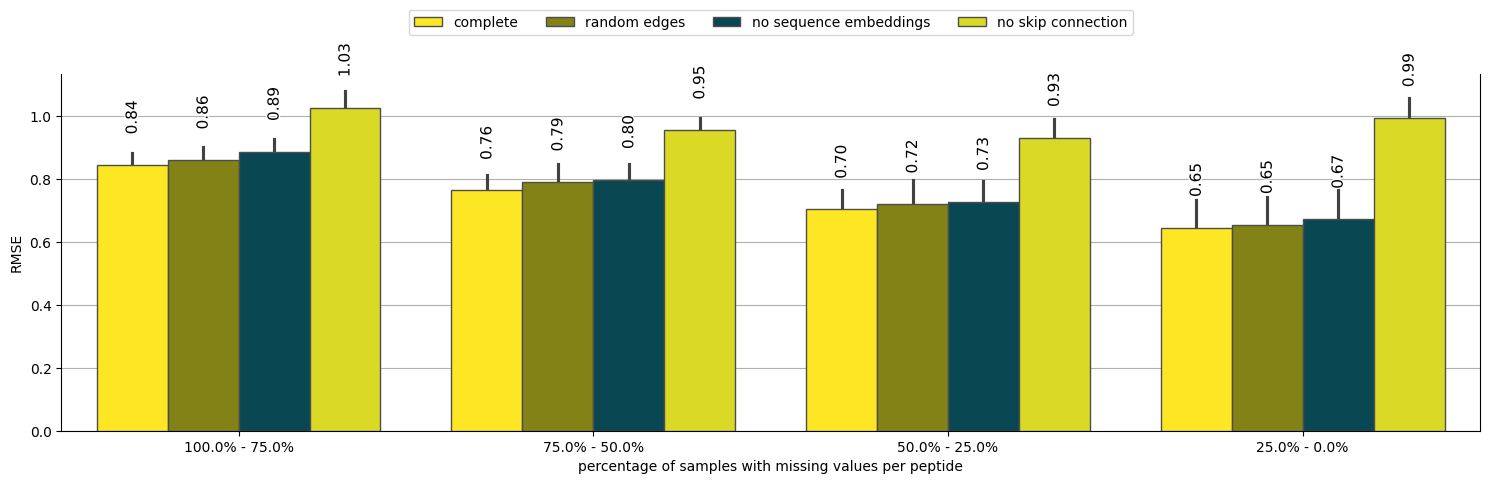

In [61]:
from matplotlib import patheffects as PathEffects

ds_names = ['prostate_cancer', 'crohns_fibrosis', 'breast_cancer', 'blood_ddia', 'human_ecoli_ddia', 'maxlfqbench']
kind_map = {'prostate_cancer':'complete',
            'prostate_cancer_random_edges':'random edges',
            'prostate_cancer_zero_sequence_embeddings':'no sequence embeddings',
            'prostate_cancer_no_skip':'no skip connection',
            'prostate_cancer_no_skip_random_edges':'no skip connection & random edges'}

col = -1
all_dfs = []
for ds_name in ablation_datasets.keys():
   ds = ablation_datasets[ds_name]
   df = thresh_rmse_dfs[ds_name].copy()
   col += 1
   df['column'] = df['column'].map(method_label_map)
   df['interval'] = (df['interval_upper']*100).astype(str) + '% - ' + (df['interval_lower']*100).astype(str) + '%'
   df = df[df['column']=='PEPerMINT']
   df['kind'] = kind_map[ds_name]
   all_dfs.append(df)
all_dfs = pd.concat(all_dfs)
num_rows = len(ablation_datasets.keys())
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.barplot(all_dfs, y='metric', x='interval', hue='kind', ax=ax,
            linewidth=1.0, edgecolor="0.3", palette=PALETTE, zorder=10, saturation=1.0)
ax.set_ylabel('RMSE')
for container in ax.containers:
   ax.bar_label(container, fmt='%.2f', label_type='edge', rotation = 90, padding=22,
                  fontsize=11, path_effects=[PathEffects.withStroke(linewidth=2, foreground='w')])#15.1)
ticks = [k.get_text() for k  in ax.get_xticklabels()]
ax.grid(axis='y', zorder=1)
ax.spines['top'].set_visible(False)
ax.set_xticks(ax.get_xticks()) # Workaround to silence a warning
ax.set_xticklabels(ticks, ha='center')
ax.set_xlabel('percentage of samples with missing values per peptide')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=6, fontsize=10)
fig.tight_layout()
fig.savefig(f'figures/ablation_rmse_stratified.pdf', bbox_inches='tight')

## Runtime

/tmp/ipykernel_1182802/1824829056.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([method_label_map[m.get_text()] for m in ax.get_xticklabels()], rotation=45, ha='right', fontsize=13)
/tmp/ipykernel_1182802/1824829056.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([method_label_map[m.get_text()] for m in ax.get_xticklabels()], rotation=45, ha='right', fontsize=13)
/tmp/ipykernel_1182802/1824829056.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([method_label_map[m.get_text()] for m in ax.get_xticklabels()], rotation=45, ha='right', fontsize=13)
/tmp/ipykernel_1182802/1824829056.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e

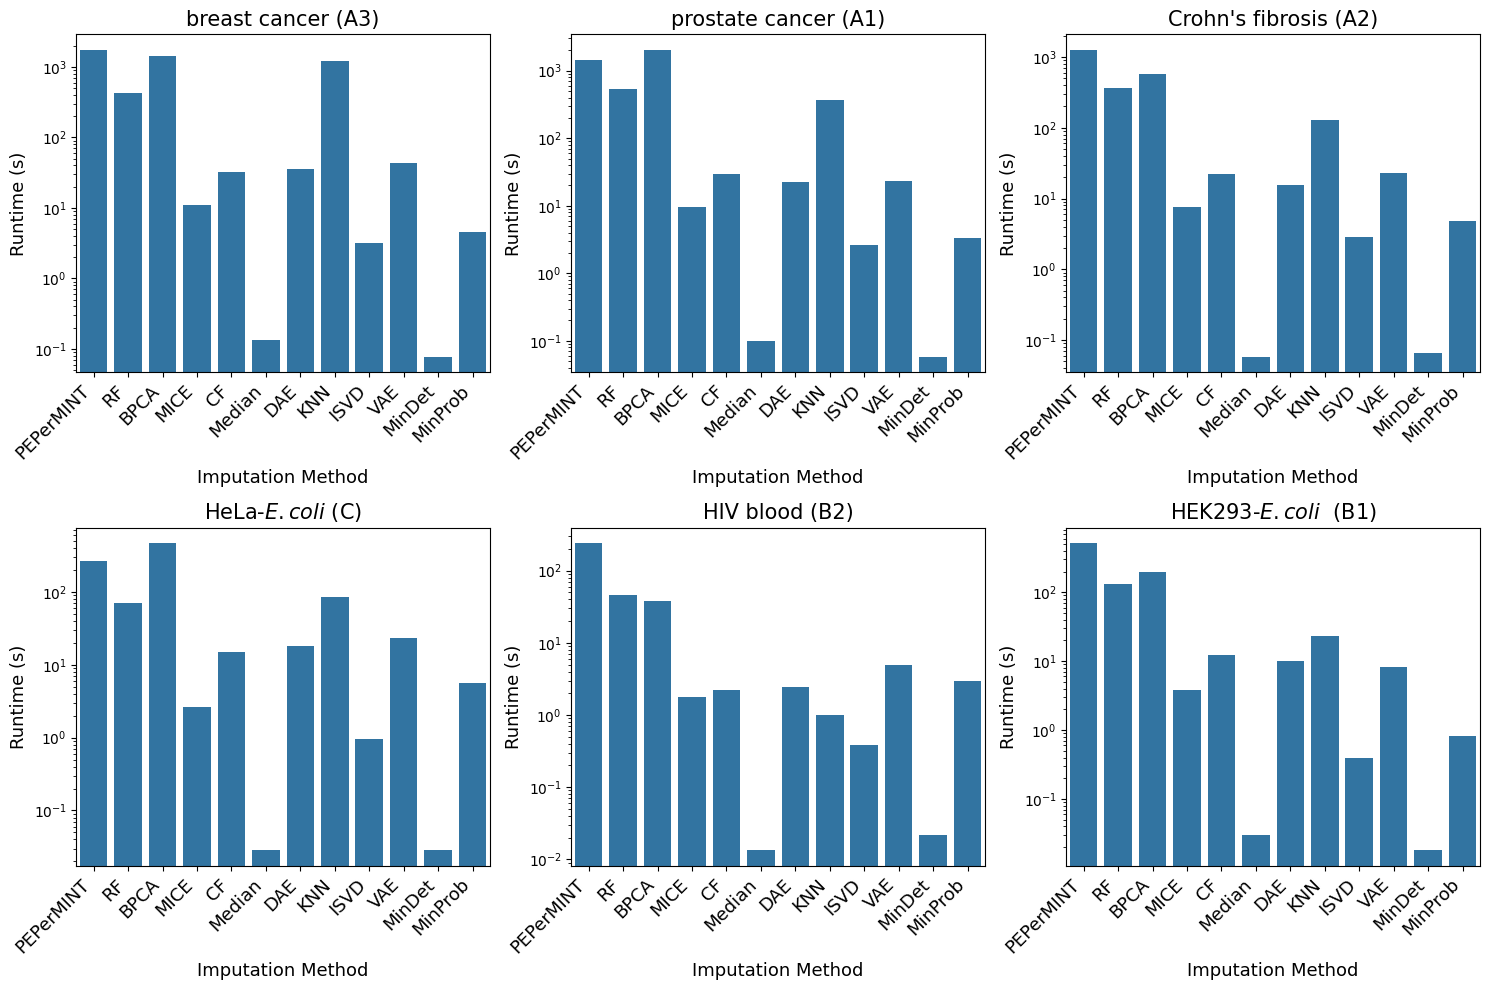

In [14]:
import math
import json
runtimes_dict = json.load(open('data/runtimes.json', 'r'))

n_ds = len(imp_datasets)
n_cols = math.ceil(n_ds/2)
fig, axs = plt.subplots(2, n_cols, figsize=(n_cols*5, 10))
axs = axs.flatten()
for ds_name, ax in zip(imp_datasets.keys(), axs):
    df = pd.DataFrame({'method': runtimes_dict[ds_name].keys(), 'runtime': runtimes_dict[ds_name].values()},
                       index=[method_label_map[m] for m in runtimes_dict[ds_name].keys()])
    df = df.loc[method_order]
    sns.barplot(data=df, x='method', y='runtime', ax=ax)
    ax.set_yscale('log')
    ax.set_ylabel('Runtime (s)', fontsize=13)
    ax.set_xlabel('Imputation Method', fontsize=13)
    ax.set_xticklabels([method_label_map[m.get_text()] for m in ax.get_xticklabels()], rotation=45, ha='right', fontsize=13)
    ax.set_title(dataset_label_map[ds_name], fontsize=15)
fig.tight_layout()
fig.savefig('figures/runtimes.pdf', bbox_inches='tight')